# COVID-19 in India: What Went So Terribly Wrong?

## Motivation

Recently, India has experienced an increase in COVID-19 cases and deaths. With insufficient medical resources and poor living conditions, many people have to unfortunately be turned away from hospitals in favor of people with more severe cases. But until now, it seemed as if India was doing well with the pandemic! So what has happened recently to change that? In this notebook we will explore that question and investigate which locations within India have it the worst and need medical resources the most.

## Data Sources

- https://github.com/datameet/covid19

    This data combines multiple data sources from Indian government websites into a cleaner and more accesible format. The government sources for COVID-19 data are the Ministry of Health & Family Welfare and The Indian Council of Medical Research, or ICMR. The data is stored in multiple files representing different pieces of data, such as the total number of cases as a time series, and the number of cases and deaths per state. Each piece of data is stored as a .json file and will need to be preprocessed so that we can work with it more easily.

- https://gist.githubusercontent.com/jbrobst/56c13bbbf9d97d187fea01ca62ea5112/raw/e388c4cae20aa53cb5090210a42ebb9b765c0a36/india_states.geojson

    This JSON file includes a list of states in India along with important geographical information. This will be used later in the project when we visualize various COVID-19 parameters on a map of India.

## Part 1: Exploring the Total Counts for India

We will start by importing some of the libraries we will need. The requests library is used to acquire the .json file from the internet and get its contents in a JSON format. The json library is then used to place that data into a local json file and convert it into a dictionary. Finally, we use pandas to convert the dictionary into a dataframe so that we can more easily plot and visualize the data.

In [36]:
import requests
import json
import pandas as pd

Because the data is stored in a specific JSON format, we need to read the JSON file from the web and read it into a JSON data structure. We will start by acquiring the all_totals.json file, which contains the totals for the number of active cases, number of deaths, number of people cured, and the total number of confirmed cases, all with the associated timestamps.

In [37]:
# Takes a JSON file from the data source and places its contents inside a dictionary
def get_json(json_file):
    link = 'https://raw.githubusercontent.com/datameet/covid19/master/data/' + json_file
    r = requests.get(link)
    data = r.json()

    # takes the data from link and saves it in a JSON file
    with open(json_file, 'w') as f:
        json.dump(data, f)

    # takes the JSON file and places the contents in a dictionary
    with open(json_file) as f:
        data = json.load(f)

    return data

In [38]:
data = get_json('all_totals.json')
data['rows'][0]

{'key': ['2020-01-30T13:33:00.00+05:30', 'active_cases'], 'value': 1}

As you can see, the data is stored in a key-value pair format, where the key contains the timestamp and attribute name, while the value contains the number associated with that attribute. We can wrangle this data format into a more table-like structure so that we can convert this dictionary into a dataframe.

In [39]:
# Takes input from the JSON dictionary and converts it into
# a new dictionary with a different format. The attributes
# found in the input ("cases", "deaths", etc.) are keys in the
# new dictionary, and the values are a single key-value pair
# of time and the value corresponding to the attribute.
def extract_data(data):
    extracted_data = {}
    rows = data["rows"]

    for row in rows:
        time, attribute, value = extract_row(row)

        if attribute not in extracted_data:
            extracted_data[attribute] = {time : value}
        else:
            extracted_data[attribute][time] = value

    return extracted_data

# Extracts the time, attribute, and value information
# from one row of the JSON dictionary. Used as a helper
# function in extract_data()
def extract_row(row):
    time = row['key'][0]
    attribute = row['key'][1]
    value = row['value']

    return time[:10], attribute, value

In [40]:
data_dict = extract_data(data)
df = pd.DataFrame(data_dict)
df

active_cases     cured   death  total_confirmed_cases
2020-01-30             1         0       0                      1
2020-02-02             2         0       0                      2
2020-02-03             3         0       0                      3
2020-03-02             5         0       0                      5
2020-03-03             6         0       0                      6
...                  ...       ...     ...                    ...
2021-05-09       3736648  18317404  242362               22296414
2021-05-10       3745237  18671222  246116               22662575
2021-05-11       3715221  19027304  249992               22992517
2021-05-12       3704099  19382642  254197               23340938
2021-05-13       3710525  19734823  258317               23703665

[435 rows x 4 columns]

There is a problem here with the date ranges, and that is that they are not continuous! If we ever want to visualize the data, it will be important to have a continuous date range. We can do this by adding new rows for the missing days, and simply taking the previous row's values as the values for the new rows. We fill in the missing values in this way because all of the metrics in the dataset are cumulative.

In [41]:
# calculate date range index using lowest and highest dates
idx = pd.date_range(df.index.min(), df.index.max())
df.index = pd.DatetimeIndex(df.index)

# reindex the data using date range, and fill any missing dates
# with the previous date's row values
df = df.reindex(index=idx, method='ffill')

df

active_cases     cured   death  total_confirmed_cases
2020-01-30             1         0       0                      1
2020-01-31             1         0       0                      1
2020-02-01             1         0       0                      1
2020-02-02             2         0       0                      2
2020-02-03             3         0       0                      3
...                  ...       ...     ...                    ...
2021-05-09       3736648  18317404  242362               22296414
2021-05-10       3745237  18671222  246116               22662575
2021-05-11       3715221  19027304  249992               22992517
2021-05-12       3704099  19382642  254197               23340938
2021-05-13       3710525  19734823  258317               23703665

[470 rows x 4 columns]

Now that we have the data in a managable format, we can start visualizing the data. Let's start by plotting the number of active cases, total number of confirmed cases, number of deaths, and number of people cured.

<AxesSubplot:>

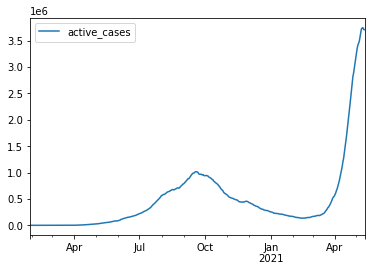

In [42]:
df.plot(y='active_cases')

<AxesSubplot:>

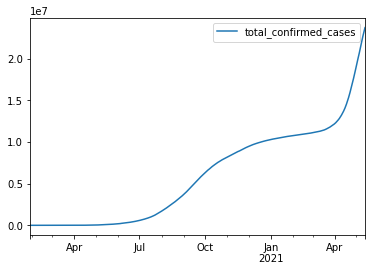

In [43]:
df.plot(y='total_confirmed_cases')

<AxesSubplot:>

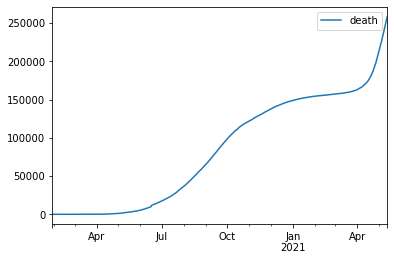

In [44]:
df.plot(y='death')

<AxesSubplot:>

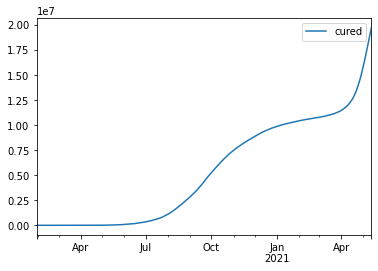

In [45]:
df.plot(y='cured')

We can very clearly see from these plots that cases and deaths have been skyrocketing starting around late March to early April 2021. This is when a new strain of the virus came to India. But what made this new strain so difficult to handle compared to any previous ones, and is the situation different by state in India? Let us try to explore this question by looking at the COVID-19 data partitioned by state. This can be found in the Ministry of Health's data, which can be located in mohfw.json.

## Part 2: Looking at the Data by State

In [46]:
data2 = get_json('mohfw.json')
data2['rows'][0]

{'id': '2020-01-30T13:33:00.00+05:30|kl',
 'key': '2020-01-30T13:33:00.00+05:30|kl',
 'value': {'_id': '2020-01-30T13:33:00.00+05:30|kl',
  '_rev': '2-727ff11254cdb1c043ab19b2714b3cab',
  'report_time': '2020-01-30T13:33:00.00+05:30',
  'state': 'kl',
  'confirmed_india': 1,
  'confirmed_foreign': 0,
  'cured': 0,
  'death': 0,
  'source': 'mohfw_pib',
  'type': 'cases',
  'confirmed': 1}}

It seems that this JSON file's format is slightly different than the all_totals's format. We can see that the rows of the data are essentially a set of key-value pairings. Let's further inspect the contents of the JSON.

In [47]:
data2['rows'][5].keys()

dict_keys(['id', 'key', 'value'])

In [48]:
data2['rows'][5]['value'].keys()

dict_keys(['_id', '_rev', 'report_time', 'state', 'confirmed_india', 'confirmed_foreign', 'cured', 'death', 'source', 'type', 'confirmed'])

In [49]:
# Adds two tuples together. This is useful for adding all of the cases
# for each state that were recorded as various timestamps.
def add_tuples(a, b):
    return tuple(map(lambda i, j: i + j, a, b))

In [50]:
# Given a state abbrevation, this function will map it to
# the corresponding state name.
def get_state_from_abbrev(abbrev):
    
    # Dictionary mapping state abbreviations to their full names
    states = {
        "ap": "Andhra Pradesh",
        "ar": "Arunachal Pradesh",
        "as": "Assam",
        "br": "Bihar",
        "ct": "Chhattisgarh",
        "ga": "Goa",
        "gj": "Gujarat",
        "hr": "Haryana",
        "hp": "Himachal Pradesh",
        "jh": "Jharkhand",
        "ka": "Karnataka",
        "kl": "Kerala",
        "mp": "Madhya Pradesh",
        "mh": "Maharashtra",
        "mn": "Manipur",
        "ml": "Meghalaya",
        "mz": "Mizoram",
        "nl": "Nagaland",
        "or": "Odisha",
        "pb": "Punjab",
        "rj": "Rajasthan",
        "sk": "Sikkim",
        "tn": "Tamil Nadu",
        "tg": "Telangana",
        "tr": "Tripura",
        "ut": "Uttarakhand",
        "up": "Uttar Pradesh",
        "wb": "West Bengal",
        "an": "Andaman and Nicobar Islands",
        "ch": "Chandigarh",
        "dn": "Dadra and Nagar Haveli",
        "dd": "Daman and Diu",
        "dl": "Delhi",
        "jk": "Jammu and Kashmir",
        "la": "Ladakh",
        "ld": "Lakshadweep",
        "py": "Pondicherry",
        "dn_dd": "Dadra and Nagar Haveli and Daman and Diu",
        "unassigned": "unassigned"
    }

    return states[abbrev]

We now want to extract the relevant data from the dictionary that is needed to display on the maps. Right now, the data is structured as time series data. For the maps, however, we are not concerned with the time cases or deaths occurred, but rather the current numbers for those statistics. Later, when we create a machine learning model for predicting the number of deaths, we will come back to the time series data.

In [51]:
# Iterates over the rows of the dictionary data and extracts the relevant
# information from the rows. The dictionary is a key-value pairing between
# state and a tuple of confirmed, cured, and death.
def extract_data2(data):
    extracted_data = {}
    rows = data["rows"]

    for row in rows:
        time, state, confirmed, cured, death = extract_row2(row)

        if state not in extracted_data:
            extracted_data[state] = (confirmed, cured, death)
        else:
            res = add_tuples(extracted_data[state], (confirmed, cured, death))
            extracted_data[state] = res

    return extracted_data

# Extracts the time, state, confirmed, cured, and death information
# from one row of the JSON dictionary. Used as a helper
# function in extract_data2()
def extract_row2(row):
    values_dict = row['value']
    time = values_dict['report_time']
    state = get_state_from_abbrev(values_dict['state'])
    confirmed = values_dict['confirmed']
    cured = values_dict['cured']
    death = values_dict['death']

    return time[:10], state, confirmed, cured, death

Let's now create the reformatted dictionary and see what value is stored at a particular key, say, Kerala.

In [52]:
extracted2 = extract_data2(data2)
extracted2['Kerala']

(200185603, 177894118, 766581)

Now that we have the dictionary properly formatted, it's time to convert it into a pandas dataframe. Pandas allows us to feed in a dictionary into the dataframe constructor, so we can simply pass extracted2 into that. For more details on how this works, see the documentation at https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html.

In [53]:
# Creates dataframe from dictionary
df2 = pd.DataFrame(extracted2)

df2 = df2.transpose() # flips the rows and columns

df2['state'] = df2.index
df2.columns = ['cases', 'cured', 'deaths', 'state']
df2.drop('unassigned', inplace=True)
df2

cases      cured    deaths  \
Kerala                                    200185603  177894118    766581   
Delhi                                     158725093  147896560   2741459   
Telangana                                  75798728   69580382    432535   
Rajasthan                                  77767638   69179429    700476   
Haryana                                    66067411   60344316    698864   
Jammu and Kashmir                          30756599   27720245    469131   
Karnataka                                 242380060  216792332   3144790   
Ladakh                                      2307394    2084230     28077   
Maharashtra                               589598167  512544984  13590012   
Punjab                                     47764245   42219368   1406438   
Tamil Nadu                                223058512  208216246   3261644   
Uttar Pradesh                             160155913  143267909   2199456   
Andhra Pradesh                            228887306  215214582   1848944   
Uttarakhand                                23199910   20397560    370919   
Odisha                                     82390133   77558828    426009   
West Bengal                               133436340  123072064   2330712   
Pondicherry                                 9996027    9076464    163604   
Chandigarh                                  5394798    4840252     77743   
Chhattisgarh                               75304232   66298558    875894   
Gujarat                                    70290062   62010591   1330100   
Himachal Pradesh                           12567361   11065632    198464   
Madhya Pradesh                             66056188   59307071    976388   
Bihar                                      69575592   64292363    381133   
Manipur                                     6347465    5796243     72359   
Mizoram                                     1009532     910925      1770   
Goa                                        13652667   12301268    188057   
Andaman and Nicobar Islands                 1283574    1211641     16203   
Assam                                      56413792   52528287    260216   
Jharkhand                                  31400674   28349151    296292   
Arunachal Pradesh                           3962184    3686314     12013   
Tripura                                     8320110    7728375     92857   
Nagaland                                    2846345    2593039     17581   
Meghalaya                                   3074017    2797072     30784   
Dadra and Nagar Haveli                          186         14         0   
Sikkim                                      1390467    1243984     26879   
Daman and Diu                                     2          0         0   
Dadra and Nagar Haveli and Daman and Diu    1022337     940814       662   
Lakshadweep                                  107535      73104       164   

                                                                             state  
Kerala                                                                      Kerala  
Delhi                                                                        Delhi  
Telangana                                                                Telangana  
Rajasthan                                                                Rajasthan  
Haryana                                                                    Haryana  
Jammu and Kashmir                                                Jammu and Kashmir  
Karnataka                                                                Karnataka  
Ladakh                                                                      Ladakh  
Maharashtra                                                            Maharashtra  
Punjab                                                                      Punjab  
Tamil Nadu                                                              Tamil Nadu  
Uttar Pradesh                                                

We can see there are some missing values (a lot actually!) that are labelled as 'unassigned.' For now we will drop these values from the table, although further analysis might be required to truly understand the effect of these values on the data overall.

Now we can proceed by trying to visualize the data on a map. The idea is to create three maps where we color states by their relative number of cases/cured/deaths. The first step is to scale down the data by a factor of a million. This will make the scales in our maps more readable.

In [54]:
# Scaling down the cases, cured, and deaths columns
df2_copy = df2.copy()
df2_copy['cases'] /= 1e6
df2_copy['cured'] /= 1e6
df2_copy['deaths'] /= 1e6
df2_copy

cases       cured     deaths  \
Kerala                                    200.185603  177.894118   0.766581   
Delhi                                     158.725093  147.896560   2.741459   
Telangana                                  75.798728   69.580382   0.432535   
Rajasthan                                  77.767638   69.179429   0.700476   
Haryana                                    66.067411   60.344316   0.698864   
Jammu and Kashmir                          30.756599   27.720245   0.469131   
Karnataka                                 242.380060  216.792332   3.144790   
Ladakh                                      2.307394    2.084230   0.028077   
Maharashtra                               589.598167  512.544984  13.590012   
Punjab                                     47.764245   42.219368   1.406438   
Tamil Nadu                                223.058512  208.216246   3.261644   
Uttar Pradesh                             160.155913  143.267909   2.199456   
Andhra Pradesh                            228.887306  215.214582   1.848944   
Uttarakhand                                23.199910   20.397560   0.370919   
Odisha                                     82.390133   77.558828   0.426009   
West Bengal                               133.436340  123.072064   2.330712   
Pondicherry                                 9.996027    9.076464   0.163604   
Chandigarh                                  5.394798    4.840252   0.077743   
Chhattisgarh                               75.304232   66.298558   0.875894   
Gujarat                                    70.290062   62.010591   1.330100   
Himachal Pradesh                           12.567361   11.065632   0.198464   
Madhya Pradesh                             66.056188   59.307071   0.976388   
Bihar                                      69.575592   64.292363   0.381133   
Manipur                                     6.347465    5.796243   0.072359   
Mizoram                                     1.009532    0.910925   0.001770   
Goa                                        13.652667   12.301268   0.188057   
Andaman and Nicobar Islands                 1.283574    1.211641   0.016203   
Assam                                      56.413792   52.528287   0.260216   
Jharkhand                                  31.400674   28.349151   0.296292   
Arunachal Pradesh                           3.962184    3.686314   0.012013   
Tripura                                     8.320110    7.728375   0.092857   
Nagaland                                    2.846345    2.593039   0.017581   
Meghalaya                                   3.074017    2.797072   0.030784   
Dadra and Nagar Haveli                      0.000186    0.000014   0.000000   
Sikkim                                      1.390467    1.243984   0.026879   
Daman and Diu                               0.000002    0.000000   0.000000   
Dadra and Nagar Haveli and Daman and Diu    1.022337    0.940814   0.000662   
Lakshadweep                                 0.107535    0.073104   0.000164   

                                                                             state  
Kerala                                                                      Kerala  
Delhi                                                                        Delhi  
Telangana                                                                Telangana  
Rajasthan                                                                Rajasthan  
Haryana                                                                    Haryana  
Jammu and Kashmir                                                Jammu and Kashmir  
Karnataka                                                                Karnataka  
Ladakh                                                                      Ladakh  
Maharashtra                                                            Maharashtra  
Punjab                                                                      Punjab  
Tamil Nadu                    

We will use the folium library, which is a wrapper around the leaflet.js library, to display the maps. Note that these types of visualizations are called choropeths.

Choropeths Tutorial: https://vverde.github.io/blob/interactivechoropleth.html

Choropeths Documentation: https://python-visualization.github.io/folium/quickstart.html#Choropleth-maps

In [55]:
import folium

# Creates a map based on India's lat/long coordinates
map_osm = folium.Map(location=[22.71, 79.04], zoom_start=5)
map_osm

In [56]:
# This function plots a given column of the dataframe onto the map of India.
#   - scheme:
#       - Color range that will be used to color the different states.
#         The scheme is specified by a string, and the available colors can be found at
#         https://github.com/python-visualization/folium/issues/403.
#   - scale:
#       - List of numbers that will decide the shade of color for a particular state.
#         The scale can also be seen visually when the choropleth is displayed.

def color_map(column, scheme, scale):
    map_osm = folium.Map(location=[22.71, 79.04], zoom_start=5)
    map_osm
    folium.Choropleth(
        # geo_data specifies the state regions that need to be colored.
        geo_data="https://gist.githubusercontent.com/jbrobst/56c13bbbf9d97d187fea01ca62ea5112/raw/e388c4cae20aa53cb5090210a42ebb9b765c0a36/india_states.geojson",
        name="choropleth",
        data=df2_copy,
        columns=["state", column], # column of data we are interested in plotting
        key_on='properties.ST_NM',
        fill_color=scheme,
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name=f"COVID-19 {column} (in millions)",
        threshold_scale=scale
    ).add_to(map_osm)

    folium.LayerControl().add_to(map_osm)
    return map_osm

In [57]:
color_map("deaths", "Reds", [0, 2.5, 5, 7.5, 10, 12.5, 15])

In [58]:
color_map("cured", "Greens", scale=[0, 100, 200, 300, 400, 500, 600])

In [59]:
color_map("cases", "Purples", scale=[0, 100, 200, 300, 400, 500, 600])

From these plots, we can seen that things seem pretty dire in Maharashta, the state where Mumbai is located. Maharashta has the greatest number of deaths, cases, and cured people. This makes a lot of sense because Mumbai, India's largest city, is located in Maharashta, and so there are some highly dense city areas there. In a city, especially a dense one, it is more difficult to socially distance, making it easier for COVID-19 to spread.

Looking at the other states, it appears that states in Southern India have it worse in number of cases, deaths, and cured people compared to Northern India. Kerala, which is in Southern India, is an interesting case study, because while it shares similar numbers in terms of cases and number of people cured, it has significantly fewer number of deaths than its neighboring states, such as Tamil Nadu and Karnataka.

## Machine Learning

We can now create a model for India's COVID-19 cases to predict how many deaths there will be in the next 3 months. We can do this by accessing the data from data2 that we previously had.

In [60]:
data2['rows'][0]['value']['death']

0

In [79]:
deaths = {}

for record in data2['rows']:
    time = record['value']['report_time']
    death = record['value']['death']

    if time in deaths:
        deaths[time] += death
    else:
        deaths[time] = death

deaths

{'2020-01-30T13:33:00.00+05:30': 0,
 '2020-02-02T10:39:00.00+05:30': 0,
 '2020-02-03T12:13:00.00+05:30': 0,
 '2020-03-02T14:28:00.00+05:30': 0,
 '2020-03-03T19:36:00.00+05:30': 0,
 '2020-03-10T12:00:00.00+05:30': 0,
 '2020-03-11T17:30:00.00+05:30': 0,
 '2020-03-12T11:00:00.00+05:30': 0,
 '2020-03-12T18:00:00.00+05:30': 0,
 '2020-03-13T10:00:00.00+05:30': 1,
 '2020-03-13T22:15:00.00+05:30': 2,
 '2020-03-14T09:00:00.00+05:30': 2,
 '2020-03-14T16:55:00.00+05:30': 2,
 '2020-03-15T08:55:00.00+05:30': 2,
 '2020-03-15T12:00:00.00+05:30': 2,
 '2020-03-15T17:00:00.00+05:30': 2,
 '2020-03-15T23:30:00.00+05:30': 2,
 '2020-03-16T16:00:00.00+05:30': 2,
 '2020-03-17T09:15:00.00+05:30': 2,
 '2020-03-17T10:55:00.00+05:30': 3,
 '2020-03-17T11:52:00.00+05:30': 3,
 '2020-03-17T17:15:00.00+05:30': 3,
 '2020-03-18T09:00:00.00+05:30': 3,
 '2020-03-18T17:15:00.00+05:30': 3,
 '2020-03-19T09:00:00.00+05:30': 3,
 '2020-03-19T16:30:00.00+05:30': 4,
 '2020-03-19T17:00:00.00+05:30': 4,
 '2020-03-20T09:00:00.00+05:

For a tutorial on how to deal with time series data for machine learning, see https://www.pluralsight.com/guides/machine-learning-for-time-series-data-in-python

Here I am adding several new variables to the data based on the datetimes originally in the data. I am doing this because it is possible that there are correlations between the number of COVID-19 related deaths and these new variables. For example, it might be the case that there are more people outside, and thus exposed to COVID-19, on weekends compared to weekdays,
so this would be an important variable to keep track of.

In [84]:
df3 = pd.DataFrame({"Datetime": deaths.keys(), "Deaths": deaths.values()})

# Converts the datetime string into a datetime object. We can then easily access
# attributes of this object, such as year, month, day, etc.
def create_datetime_variables(df3):
    df3['Datetime'] = pd.DatetimeIndex(df3['Datetime'])

    df3['Year'] = df3['Datetime'].dt.year
    df3['Month'] = df3['Datetime'].dt.month
    df3['Day'] = df3['Datetime'].dt.day

    df3['weekday'] = df3['Datetime'].dt.weekday

    df3['Hours'] = df3['Datetime'].dt.hour
    df3['Minutes'] = df3['Datetime'].dt.minute
    df3['Seconds'] = df3['Datetime'].dt.second

    return df3

df3 = create_datetime_variables(df3)
df3

Datetime  Deaths  Year  Month  Day  weekday  Hours  \
0   2020-01-30 13:33:00+05:30       0  2020      1   30        3     13   
1   2020-02-02 10:39:00+05:30       0  2020      2    2        6     10   
2   2020-02-03 12:13:00+05:30       0  2020      2    3        0     12   
3   2020-03-02 14:28:00+05:30       0  2020      3    2        0     14   
4   2020-03-03 19:36:00+05:30       0  2020      3    3        1     19   
..                        ...     ...   ...    ...  ...      ...    ...   
491 2021-05-09 08:00:00+05:30  242362  2021      5    9        6      8   
492 2021-05-10 08:00:00+05:30  246116  2021      5   10        0      8   
493 2021-05-11 08:00:00+05:30  249992  2021      5   11        1      8   
494 2021-05-12 08:00:00+05:30  254197  2021      5   12        2      8   
495 2021-05-13 08:00:00+05:30  258317  2021      5   13        3      8   

     Minutes  Seconds  
0         33        0  
1         39        0  
2         13        0  
3         28        0  
4         36        0  
..       ...      ...  
491        0        0  
492        0        0  
493        0        0  
494        0        0  
495        0        0  

[496 rows x 9 columns]

Looks like the seconds column has a lot of zeroes ... let's check for sure whether it is all zeroes. If it is, we can safely remove that piece of data.

In [63]:
df3.value_counts(subset='Seconds')

Seconds
0    496
dtype: int64

Now removing seconds from the dataframe, since all 496 values are 0 ...

In [64]:
df3.drop('Seconds', axis=1, inplace=True)
df3

Datetime  Deaths  Year  Month  Day  weekday  Hours  \
0   2020-01-30 13:33:00+05:30       0  2020      1   30        3     13   
1   2020-02-02 10:39:00+05:30       0  2020      2    2        6     10   
2   2020-02-03 12:13:00+05:30       0  2020      2    3        0     12   
3   2020-03-02 14:28:00+05:30       0  2020      3    2        0     14   
4   2020-03-03 19:36:00+05:30       0  2020      3    3        1     19   
..                        ...     ...   ...    ...  ...      ...    ...   
491 2021-05-09 08:00:00+05:30  242362  2021      5    9        6      8   
492 2021-05-10 08:00:00+05:30  246116  2021      5   10        0      8   
493 2021-05-11 08:00:00+05:30  249992  2021      5   11        1      8   
494 2021-05-12 08:00:00+05:30  254197  2021      5   12        2      8   
495 2021-05-13 08:00:00+05:30  258317  2021      5   13        3      8   

     Minutes  
0         33  
1         39  
2         13  
3         28  
4         36  
..       ...  
491        0  
492        0  
493        0  
494        0  
495        0  

[496 rows x 8 columns]

Although year and month are numbers in the dataset, they are still considered categorical variables because numerical operations (such as adding two years) do not really make sense. For this reason, we need to convert these categorical variables into numeric values. We will do this by creating extra variables for each year and month.

Learn more about the get_dummies function from the documentation:
https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html

In [65]:
# drop_first parameters removes the first column created by the categorical variable
# to avoid the dummy variable trap. For example, for year, we remove the year_2020 column.
df3 = pd.get_dummies(df3, columns=['Year'], drop_first=True, prefix='year')
df3 = pd.get_dummies(df3, columns=['Month'], drop_first=True, prefix='month')
df3 = pd.get_dummies(df3, columns=['weekday'], drop_first=True, prefix='wday')
df3

Datetime  Deaths  Day  Hours  Minutes  year_2021  \
0   2020-01-30 13:33:00+05:30       0   30     13       33          0   
1   2020-02-02 10:39:00+05:30       0    2     10       39          0   
2   2020-02-03 12:13:00+05:30       0    3     12       13          0   
3   2020-03-02 14:28:00+05:30       0    2     14       28          0   
4   2020-03-03 19:36:00+05:30       0    3     19       36          0   
..                        ...     ...  ...    ...      ...        ...   
491 2021-05-09 08:00:00+05:30  242362    9      8        0          1   
492 2021-05-10 08:00:00+05:30  246116   10      8        0          1   
493 2021-05-11 08:00:00+05:30  249992   11      8        0          1   
494 2021-05-12 08:00:00+05:30  254197   12      8        0          1   
495 2021-05-13 08:00:00+05:30  258317   13      8        0          1   

     month_2  month_3  month_4  month_5  ...  month_9  month_10  month_11  \
0          0        0        0        0  ...        0         0         0   
1          1        0        0        0  ...        0         0         0   
2          1        0        0        0  ...        0         0         0   
3          0        1        0        0  ...        0         0         0   
4          0        1        0        0  ...        0         0         0   
..       ...      ...      ...      ...  ...      ...       ...       ...   
491        0        0        0        1  ...        0         0         0   
492        0        0        0        1  ...        0         0         0   
493        0        0        0        1  ...        0         0         0   
494        0        0        0        1  ...        0         0         0   
495        0        0        0        1  ...        0         0         0   

     month_12  wday_1  wday_2  wday_3  wday_4  wday_5  wday_6  
0           0       0       0       1       0       0       0  
1           0       0       0       0       0       0       1  
2           0       0       0       0       0       0       0  
3           0       0       0       0       0       0       0  
4           0       1       0       0       0       0       0  
..        ...     ...     ...     ...     ...     ...     ...  
491         0       0       0       0       0       0       1  
492         0       0       0       0       0       0       0  
493         0       1       0       0       0       0       0  
494         0       0       1       0       0       0       0  
495         0       0       0       1       0       0       0  

[496 rows x 23 columns]

Now that we have created the necessary variables, it's time to start machine learning. I will start by dividing the data into training and test sets by an 80-20 split.

In [66]:
from sklearn.model_selection import train_test_split
import numpy as np

X = df3.iloc[:, 2:] # this gets all the columns of the data besides the Deaths column
y = np.array(df3['Deaths'].values) # df3['Deaths'] is a Series, we only want the values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.20, random_state=42)

Now that we have the data split appropriately, it's time to create a model. We will use a Decision Tree as our first basic model to see how well it performs.

In [67]:
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

Here we create the Decision Tree model and evaluate its performance using the root of the mean squared error (RMSE) and the r^2 correlation coefficient.

In [68]:
# This functions evaluates a model's performance on provided training and test datsets
# using the RMSE and r^2 statistics. The model is fitted to the data, then asked to
# make predictions on the training and test sets, which can then be used to compute
# the model's accuracy on the statistical measures.
def evaluate(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    
    # Train
    pred_train_tree= model.predict(X_train)
    print(np.sqrt(mean_squared_error(y_train,pred_train_tree)))
    print(r2_score(y_train, pred_train_tree))

    # Test
    pred_test_tree= model.predict(X_test)
    print(np.sqrt(mean_squared_error(y_test,pred_test_tree)))
    print(r2_score(y_test, pred_test_tree))


In [69]:
dtree = DecisionTreeRegressor(max_depth=10, min_samples_leaf=0.05, random_state=3)
evaluate(dtree, X_train, y_train, X_test, y_test)

20312.731090822366
0.9220945117143983
31115.479604373548
0.8108586299390869


It seems that the RMSEs of both testing and training are relatively low compared to the numbers in the dataset (which were in the ten millions), and the training and testing accuracies are pretty good! But let's see if we can do even better with a different model.

Here we are using a random forest model and evaluating its performance in the same way.

In [70]:
model_rf = RandomForestRegressor(n_estimators=2000, oob_score=True, random_state=100)
evaluate(model_rf, X_train, y_train, X_test, y_test)

1915.2780702096438
0.9993073799048235
3258.5495662973694
0.9979256492406713


We can see that here we are doing phenomally well, even better than with the Decision Tree. The RMSEs are somewhat lower than for the Decision Tree, and the accuracies in training and testing are much better. Let us see the number of deaths predicted for India overall now.

In [166]:
def new_date(startDate, year, month, day):
    return datetime.datetime(year, month, day, startDate.hour, startDate.minute, startDate.second, startDate.microsecond)

In [172]:
def generate_datetimes(years, months, days, year_step, month_step, day_step):
    current = datetime.datetime.now()
    dates = [current]

    for year in range(current.year, current.year + years, year_step):
        for month in range(current.month, current.month + months, month_step):
            for day in range(current.day, current.day + days, day_step):
                if month < 12 and day < 28:
                    date = new_date(current, year, month, day)
                    dates.append(date)

    return dates

In [232]:
dates = generate_datetimes(1, 3, 28, 1, 1, 5)
dates

[datetime.datetime(2021, 5, 14, 22, 21, 46, 852506),
 datetime.datetime(2021, 5, 14, 22, 21, 46, 852506),
 datetime.datetime(2021, 5, 19, 22, 21, 46, 852506),
 datetime.datetime(2021, 5, 24, 22, 21, 46, 852506),
 datetime.datetime(2021, 6, 14, 22, 21, 46, 852506),
 datetime.datetime(2021, 6, 19, 22, 21, 46, 852506),
 datetime.datetime(2021, 6, 24, 22, 21, 46, 852506),
 datetime.datetime(2021, 7, 14, 22, 21, 46, 852506),
 datetime.datetime(2021, 7, 19, 22, 21, 46, 852506),
 datetime.datetime(2021, 7, 24, 22, 21, 46, 852506)]

In [220]:
df4 = pd.DataFrame(dates)
df4.columns = ['Datetime']
df4 = create_datetime_variables(df4)
df4

Datetime  Year  Month  Day  weekday  Hours  Minutes  \
0 2021-05-14 22:03:47.119701  2021      5   14        4     22        3   
1 2021-05-14 22:03:47.119701  2021      5   14        4     22        3   
2 2021-05-19 22:03:47.119701  2021      5   19        2     22        3   
3 2021-05-24 22:03:47.119701  2021      5   24        0     22        3   
4 2021-06-14 22:03:47.119701  2021      6   14        0     22        3   
5 2021-06-19 22:03:47.119701  2021      6   19        5     22        3   
6 2021-06-24 22:03:47.119701  2021      6   24        3     22        3   
7 2021-07-14 22:03:47.119701  2021      7   14        2     22        3   
8 2021-07-19 22:03:47.119701  2021      7   19        0     22        3   
9 2021-07-24 22:03:47.119701  2021      7   24        5     22        3   

   Seconds  
0       47  
1       47  
2       47  
3       47  
4       47  
5       47  
6       47  
7       47  
8       47  
9       47

In [221]:
df4 = pd.get_dummies(df4, columns=['Year'], prefix='year')
df4.iloc[:, 1:]

Month  Day  weekday  Hours  Minutes  Seconds  year_2021
0      5   14        4     22        3       47          1
1      5   14        4     22        3       47          1
2      5   19        2     22        3       47          1
3      5   24        0     22        3       47          1
4      6   14        0     22        3       47          1
5      6   19        5     22        3       47          1
6      6   24        3     22        3       47          1
7      7   14        2     22        3       47          1
8      7   19        0     22        3       47          1
9      7   24        5     22        3       47          1

In [222]:
empty_cols = ['month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'month_12', 'wday_1', 'wday_2', 'wday_3', 'wday_4',
       'wday_5', 'wday_6']

for col in empty_cols:
    if col not in df4:
        df4[col] = 0

In [223]:
df4.drop(columns=['Month', 'Seconds', 'weekday'], inplace=True)

In [224]:
df4.iloc[:, 1:]

Day  Hours  Minutes  year_2021  month_2  month_3  month_4  month_5  \
0   14     22        3          1        0        0        0        0   
1   14     22        3          1        0        0        0        0   
2   19     22        3          1        0        0        0        0   
3   24     22        3          1        0        0        0        0   
4   14     22        3          1        0        0        0        0   
5   19     22        3          1        0        0        0        0   
6   24     22        3          1        0        0        0        0   
7   14     22        3          1        0        0        0        0   
8   19     22        3          1        0        0        0        0   
9   24     22        3          1        0        0        0        0   

   month_6  month_7  ...  month_9  month_10  month_11  month_12  wday_1  \
0        0        0  ...        0         0         0         0       0   
1        0        0  ...        0         0         0         0       0   
2        0        0  ...        0         0         0         0       0   
3        0        0  ...        0         0         0         0       0   
4        0        0  ...        0         0         0         0       0   
5        0        0  ...        0         0         0         0       0   
6        0        0  ...        0         0         0         0       0   
7        0        0  ...        0         0         0         0       0   
8        0        0  ...        0         0         0         0       0   
9        0        0  ...        0         0         0         0       0   

   wday_2  wday_3  wday_4  wday_5  wday_6  
0       0       0       0       0       0  
1       0       0       0       0       0  
2       0       0       0       0       0  
3       0       0       0       0       0  
4       0       0       0       0       0  
5       0       0       0       0       0  
6       0       0       0       0       0  
7       0       0       0       0       0  
8       0       0       0       0       0  
9       0       0       0       0       0  

[10 rows x 21 columns]

In [225]:
X

Day  Hours  Minutes  year_2021  month_2  month_3  month_4  month_5  \
0     30     13       33          0        0        0        0        0   
1      2     10       39          0        1        0        0        0   
2      3     12       13          0        1        0        0        0   
3      2     14       28          0        0        1        0        0   
4      3     19       36          0        0        1        0        0   
..   ...    ...      ...        ...      ...      ...      ...      ...   
491    9      8        0          1        0        0        0        1   
492   10      8        0          1        0        0        0        1   
493   11      8        0          1        0        0        0        1   
494   12      8        0          1        0        0        0        1   
495   13      8        0          1        0        0        0        1   

     month_6  month_7  ...  month_9  month_10  month_11  month_12  wday_1  \
0          0        0  ...        0         0         0         0       0   
1          0        0  ...        0         0         0         0       0   
2          0        0  ...        0         0         0         0       0   
3          0        0  ...        0         0         0         0       0   
4          0        0  ...        0         0         0         0       1   
..       ...      ...  ...      ...       ...       ...       ...     ...   
491        0        0  ...        0         0         0         0       0   
492        0        0  ...        0         0         0         0       0   
493        0        0  ...        0         0         0         0       1   
494        0        0  ...        0         0         0         0       0   
495        0        0  ...        0         0         0         0       0   

     wday_2  wday_3  wday_4  wday_5  wday_6  
0         0       1       0       0       0  
1         0       0       0       0       1  
2         0       0       0       0       0  
3         0       0       0       0       0  
4         0       0       0       0       0  
..      ...     ...     ...     ...     ...  
491       0       0       0       0       1  
492       0       0       0       0       0  
493       0       0       0       0       0  
494       1       0       0       0       0  
495       0       1       0       0       0  

[496 rows x 21 columns]

In [227]:
df4.iloc[:, 1:].columns == X.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [228]:
model_rf.predict(df4.iloc[:, 1:])

array([152507.395, 152507.395, 153601.792, 153675.184, 152507.395,
       153601.792, 153675.184, 152507.395, 153601.792, 153675.184])

## Conclusion

Our model shows that in 3 months of time, India's deaths are expected to overall decrease to around 153,000 per day. This is still a large number, but it is lower than the current death estimates.